In [8]:
import numpy as np
from scipy import fftpack
import tensorly as tl 
import time
from tensorly.decomposition import tucker
import tensorsketch
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle 
import simulation
plt.style.use('seaborn-paper')
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import scipy.io
from brokenaxes import brokenaxes
from matplotlib.ticker import FormatStrFormatter
from plot_util import *

In [9]:
def sim_name(gen_type,r,noise_level,dim, rm_typ): 
    """
    Obtain the file name to use for a given simulation setting
    """
    if noise_level == 0: 
        noise = "no"
    else: 
        noise = str(int(np.log10(noise_level)))
    return "data/typ"+gen_type+"_r"+str(r)+"_noise"+noise+"_dim"+str(dim)+ "_" + rm_typ
def gen_sparse_ten(n,nnz,r, dim = 3,noise_level = 1e-3):
    """ 
    Generate sparse tensor based on TensorSketch (https://papers.nips.cc/paper/8213-low-rank-tucker-decomposition-of-large-tensors-using-tensorsketch)
    The number of non-zero entry of the obtain tensor is approximately nnz. 
    """
    density = (1 - (1 - nnz**(1/dim)/n)**(1/r))*r
    core_tensor = np.random.normal(0,1,[r for _ in range(dim)])
    arms = []
    tensor = core_tensor
    for i in np.arange(dim): 
        arm =  np.random.normal(0,1,size = (n,r))
        arm = arm*np.random.binomial(1,density,size=(n,r))
        arms.append(arm)
        tensor = tl.tenalg.mode_dot(tensor, arm, mode=i) 
    tensor0 = tensor
    tensor = tensor + np.random.normal(0,1,size = [n for _ in range(dim)])*noise_level
    return tensor, tensor0 

def avg_sim_list(sim_list): 
    sim_list_new = []
    for sims in sim_list: 
        sim_list_new.append(np.mean(sims, axis = 0)) 
    return sim_list_new

def TS_mem_cost(K,r = 10,dim = 3): 
    """
    Total memory cost for using TensorSketch 
    """
    return K*r**(2*dim-2) + K*r**(2*dim)
def one_pass_mem_cost(k,dim = 3,n = 300):
    """
    Total memory cost for using one-pass sketching 
    """
    return k*dim*n + (2*k+1)**dim

def mem_to_K(mem, r = 10, dim = 3):  
    
    # Here, we do not set K to be integer, since K is just a constant, and we only need J1,J2 to be integer
    return (mem/r**(2*dim -2)/(r**2+1))

In [12]:
import matlab.engine
eng = matlab.engine.start_matlab()
def fig1_reprun(gen_type,ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod"): 
    """
    Simulate multiple datasets with different n for multiple runs. For each run, perform the HOOI, 
    two pass sketching, and one pass sketching 
    
    :param gen_type: Type of random matrix used in sketching, including 'u' uniform, 'g' gaussian, 'sp'
        sparse radamacer. 
    :param r: tucker rank of the simulated tensor 
    :param noise_level: noise level. It inverse equals to the signal-to-noise ratio.  
    :param ns: array of different n, the side length of the square tensor 
    :param dim: the dimension of the square tensor 
    :param sim_runs: num of simulated runs in each setting 
    :param random_seed: random seed for generating the random matrix  
    """
    ss = 2*ks+1
    Ks = np.array([mem_to_K(one_pass_mem_cost(k, dim, n),r,dim) for k in ks])
    J1s = (Ks*r**(dim-1)).astype(int)
    J2s = (Ks*r**dim).astype(int)
    
    hooi_rerr = np.zeros((sim_runs, len(ks)))
    two_pass_rerr = np.zeros((sim_runs,len(ks)))
    one_pass_rerr = np.zeros((sim_runs,len(ks)))
    als_rerr = np.zeros((sim_runs, len(ks)))
    ts_rerr = np.zeros((sim_runs, len(ks)))
    ttmts_rerr = np.zeros((sim_runs, len(ks)))
    
    # Since r is not updated, the result for ALS is only needed once.
    Y = square_tensor_gen(n, r0, dim = dim, typ = gen_type, noise_level = noise_level, seed = random_seed)[0]
    Ymatlab = matlab.double(Y.tolist())
    rerr_als = eng.tucker_als_err(Ymatlab,matlab.int16([r for _ in range(dim)]),1e-4,100)
    for i in range(sim_runs): 
        for idx, k in enumerate(ks): 
            k = ks[idx]
            s = ss[idx]            
            tapprox = tensorsketch.tensor_approx.TensorApprox( Y, [r for _ in range(dim)], ks = [k for _ in range(dim)], \
                ss = [s for _ in range(dim)], random_seed = 1, rm_typ = rm_typ, store_phis = True) 
            Y_hat_hooi, _, _, _, (_, recover_time) = tapprox.tensor_approx('hooi')
            if s > n: 
                rerr_onepass = one_pass_rerr[i,idx-1]
            else:
                Y_hat_onepass, _, _, _, (_, recover_time) = tapprox.tensor_approx('onepass')
                rerr_onepass = tensorsketch.util.eval_rerr(Y,Y_hat_onepass,Y)  
            if k > n:  
                rerr_twopass = two_pass_rerr[i,idx-1]
            else: 
                Y_hat_twopass, _, _, _, (_, recover_time) = tapprox.tensor_approx('twopass')
                rerr_twopass = tensorsketch.util.eval_rerr(Y,Y_hat_twopass,Y)
            rerr_hooi = tensorsketch.util.eval_rerr(Y,Y_hat_hooi,Y)
            hooi_rerr[i,idx] = rerr_hooi
            two_pass_rerr[i,idx] = rerr_twopass
            one_pass_rerr[i,idx] = rerr_onepass
            print(rerr_twopass)
            print(rerr_onepass)
            J1 = matlab.int64([J1s[idx]])
            J2 = matlab.int64([J2s[idx]])
            if (J1s[idx] < n**(dim-1)) & (J2s[idx] < n**dim): 
                rerr_ts = eng.tucker_ts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            else: 
                rerr_ts = ts_rerr[i,idx-1]
            rerr_ttmts = 0
            # rerr_ttmts = eng.tucker_ttmts_err(Ymatlab,matlab.int16([r for _ in range(dim)]),J1,J2,1e-4, 100)
            # Sometimes, there are errors
            assert(rerr_als - rerr_hooi < 0.001)
            als_rerr[i,idx] = rerr_als 
            ts_rerr[i,idx] = rerr_ts
            ttmts_rerr[i,idx] = rerr_ttmts
    sim_list = [hooi_rerr, two_pass_rerr,one_pass_rerr, ts_rerr, ttmts_rerr, als_rerr]
    if gen_type in ['lk', 'slk']: 
        if noise_level == 0.01: 
            noise_str = "lnoise"
        elif noise_level == 0.1: 
            noise_str = "mnoise"
        elif noise_level == 1:
            noise_str = "hnoise"
        pickle.dump(sim_list, open("data/sim_fig1_"+gen_type+"_" +noise_str+".pickle", "wb" ) )
    else: 
        pickle.dump(sim_list, open("data/sim_fig1_"+gen_type+".pickle", "wb" ) )
    return sim_list

ModuleNotFoundError: No module named 'matlab'

In [4]:
"""
sim_fig1_lk_lnoise =fig1_reprun('lk',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") 
sim_fig1_lk_mnoise =fig1_reprun('lk',ks = ks, r0 =10, r = 10, noise_level = 0.1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") 
sim_fig1_lk_hnoise =fig1_reprun('lk',ks = ks, r0 =10, r = 10, noise_level = 1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") 

sim_fig1_slk_lnoise =fig1_reprun('slk',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_slk_mnoise =fig1_reprun('slk',ks = ks, r0 =10, r = 10, noise_level = 0.1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_slk_hnoise =fig1_reprun('slk',ks = ks, r0 =10, r = 10, noise_level = 1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")

sim_fig1_spd =fig1_reprun('spd',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_fpd =fig1_reprun('fpd',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_fed =fig1_reprun('fed',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
sim_fig1_sed =fig1_reprun('sed',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")
"""


'\nsim_fig1_lk_lnoise =fig1_reprun(\'lk\',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") \nsim_fig1_lk_mnoise =fig1_reprun(\'lk\',ks = ks, r0 =10, r = 10, noise_level = 0.1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") \nsim_fig1_lk_hnoise =fig1_reprun(\'lk\',ks = ks, r0 =10, r = 10, noise_level = 1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod") \n\nsim_fig1_slk_lnoise =fig1_reprun(\'slk\',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")\nsim_fig1_slk_mnoise =fig1_reprun(\'slk\',ks = ks, r0 =10, r = 10, noise_level = 0.1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")\nsim_fig1_slk_hnoise =fig1_reprun(\'slk\',ks = ks, r0 =10, r = 10, noise_level = 1,n = 300, dim = 3, sim_runs = 1,random_seed = 1, rm_typ = "gprod")\n\nsim_fig1_spd =fig1_reprun(\'spd\',ks = ks, r0 =10, r = 10, noise_level = 1e-2,n = 300, dim =

In [5]:
sim_fig1_lk_lnoise = pickle.load(open("data/sim_fig1_lk_lnoise" +".pickle", "rb"))
sim_fig1_lk_mnoise = pickle.load(open("data/sim_fig1_lk_mnoise" +".pickle", "rb"))
sim_fig1_lk_hnoise = pickle.load(open("data/sim_fig1_lk_hnoise" +".pickle", "rb"))
sim_fig1_slk_lnoise = pickle.load(open("data/sim_fig1_slk_lnoise" +".pickle", "rb"))
sim_fig1_slk_mnoise = pickle.load(open("data/sim_fig1_slk_mnoise" +".pickle", "rb"))
sim_fig1_slk_hnoise = pickle.load(open("data/sim_fig1_slk_hnoise" +".pickle", "rb"))
sim_fig1_spd = pickle.load(open("data/sim_fig1_spd" +".pickle", "rb"))
sim_fig1_fpd = pickle.load(open("data/sim_fig1_fpd" +".pickle", "rb"))
#sim_fig1_sed = pickle.load(open("data/sim_fig1_sed" +".pickle", "rb"))
#sim_fig1_fed = pickle.load(open("data/sim_fig1_fed" +".pickle", "rb"))

In [6]:
def fig1_repplot0(sim_list,ks,name, gen_type = 'slk',noise_level= 0.01,n = 300, r = 10, dim = 3,fontsize = 28, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
            
    if outside: 
        plt.figure(figsize=(6,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    set_plot(fontsize)

    hooi_result = sim_list[0]
    two_pass_result = (sim_list[1]) #/sim_list[0])
    one_pass_result = (sim_list[2]) #/sim_list[0])
    ts_result = (sim_list[3]) #/sim_list[0])
    ttmts_result = (sim_list[4]) #/sim_list[0])
    als_result =(sim_list[5])
    
    ss = 2*ks+1
    Ks = np.array([mem_to_K(one_pass_mem_cost(k, dim, n),r,dim) for k in ks])
    J1s = (Ks*r**(dim-1)).astype(int)
    J2s = (Ks*r**dim).astype(int)
    
    mem1 = ((2*ks + 1)**dim + dim*ks*n) 
    mem2 = (J2s*(r**dim) + J1s*(r**(dim-1)))
    alldata = []
    plt.plot(mem1, np.array(two_pass_result)-np.array(als_result), label = 'Two Pass', markersize = 10, marker = marker('2pass', 'gprod'), color = marker_color('2pass', 'gprod'), markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem1, np.array(one_pass_result)-np.array(als_result), label = 'One Pass', markersize = 10, marker = marker('1pass', 'gprod'), color = marker_color('1pass', 'gprod'), markeredgewidth=1, markerfacecolor='None')
    plt.plot(mem2, np.array(ts_result)-np.array(als_result), label = 'TS', markersize = 10, marker = marker('TS', 'gprod'), color = marker_color('TS', 'gprod'),  markeredgewidth=1, markerfacecolor='None')

    alldata.append(np.array(two_pass_result)-np.array(als_result))
    alldata.append(np.array(one_pass_result)-np.array(als_result))
    alldata.append(np.array(ts_result)-np.array(als_result))
    
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Storage', ha='center',fontsize =fontsize)
    if noise_level == 0.01: 
        noise_str = "lnoise"
    elif noise_level == 0.1: 
        noise_str = "mnoise"
    elif noise_level == 1:
        noise_str = "hnoise"
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title(find_gen_label(gen_type), fontsize = fontsize)
    
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)
    ymin = np.min(alldata)
    ymax = 10**np.ceil(np.log10(ymax))
    ymin = 10**np.floor(np.log10(ymin))
    plt.ylim(ymin, ymax)
    plt.ylabel('Regret', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1, 0.85))
    plt.savefig('plots/journal/'+name,bbox_inches = "tight",pad_inches=0)
    plt.show()
    

In [7]:
fig1_repplot0(avg_sim_list(sim_fig1_lk_lnoise), ks = ks, gen_type = 'lk', noise_level = 0.01, name = 'fig1_lk_lnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_lk_mnoise), ks = ks, gen_type = 'lk', noise_level = 0.1, name = 'fig1_lk_mnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_lk_hnoise), ks = ks, gen_type = 'lk', noise_level = 1, name = 'fig1_lk_hnoise.pdf',n =300, outside = True)


fig1_repplot0(avg_sim_list(sim_fig1_slk_lnoise), ks = ks, gen_type = 'slk', noise_level = 0.01, name = 'fig1_slk_lnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_slk_mnoise), ks = ks, gen_type = 'slk', noise_level = 0.1, name = 'fig1_slk_mnoise.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_slk_hnoise), ks = ks, gen_type = 'slk', noise_level = 1, name = 'fig1_slk_hnoise.pdf',n =300)


fig1_repplot0(avg_sim_list(sim_fig1_spd), ks = ks, gen_type = 'spd', name = 'fig1_spd.pdf',n =300)
fig1_repplot0(avg_sim_list(sim_fig1_fpd), ks = ks, gen_type = 'fpd', name = 'fig1_fpd.pdf',n =300)
#fig1_repplot0(avg_sim_list(sim_fig1_sed), ks = ks, gen_type = 'sed', name = 'fig1_sed.pdf',n =300)
#fig1_repplot0(avg_sim_list(sim_fig1_fed), ks = ks, gen_type = 'fed', name = 'fig1_fed.pdf',n =300)


NameError: name 'ks' is not defined

# Fix r, Vary k setting

In [5]:
def journal_nssim(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 28, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    sim_list = []
    if outside: 
        plt.figure(figsize = (6,5))
    else: 
        plt.figure(figsize = (6,5))
    set_plot(fontsize)
    alldata = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))        
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hosvd_result = np.mean(sim_list[i][plot_id][2],0) 
        one_pass_result_diff = np.mean(sim_list[i][plot_id][1],0) - hosvd_result
        alldata.append(one_pass_result_diff)
        plt.plot(ks/n, one_pass_result_diff, label = find_rm_label(rm_typ), markersize = 10, marker = marker('1pass', rm_typ), color = marker_color('1pass',rm_typ), markeredgewidth=1, markerfacecolor='None') 
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title(find_gen_label(gen_type), fontsize = fontsize)
    # plt.legend(loc = 'best', fontsize = fontsize)
    plt.yscale('log')
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)
    ymin = np.min(alldata)
    ymax = 10**np.ceil(np.log10(ymax))
    ymin = 10**np.floor(np.log10(ymin))
    plt.ylim(ymin, ymax)
    if outside: 
        leg = plt.legend(fontsize = fontsize, bbox_to_anchor=(2, 0.85))
    plt.xlabel('k/I')
    plt.ylabel('Regret')  
    plt.savefig('plots/journal/'+name,bbox_inches = "tight",pad_inches=0)
    plt.show()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


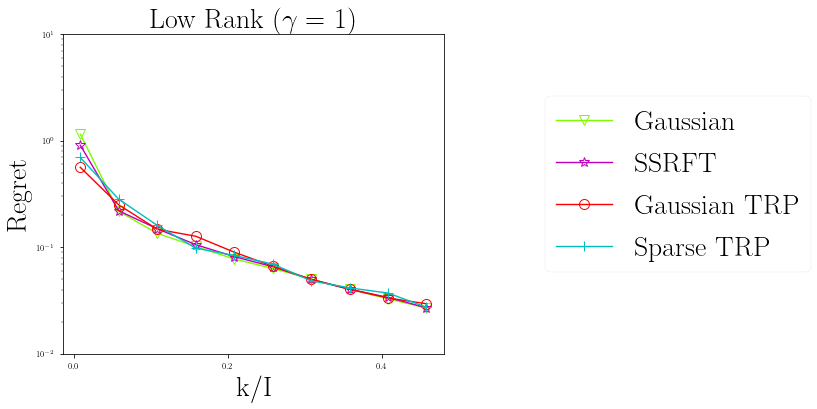

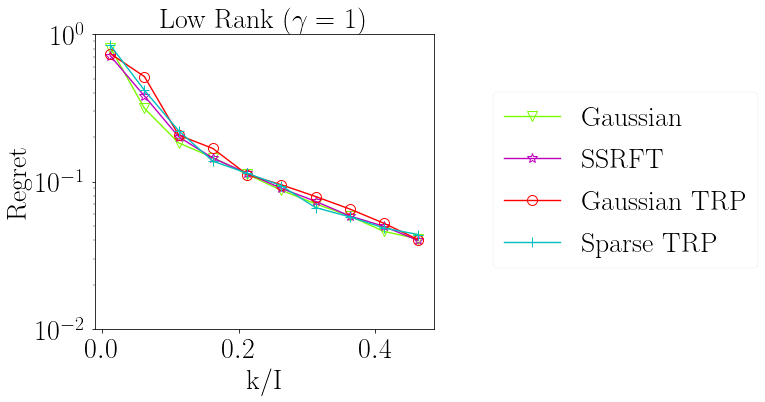

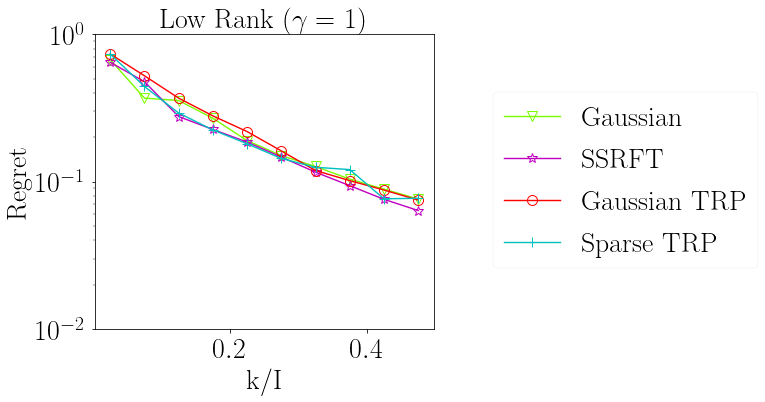

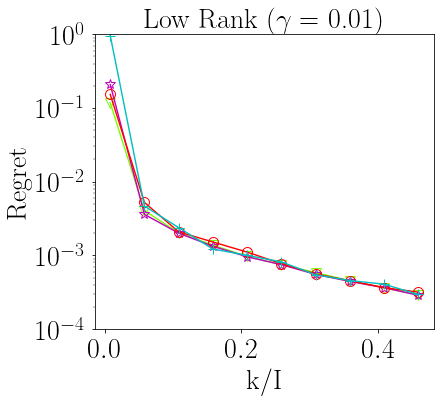

KeyboardInterrupt: 

In [6]:
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_600.pdf",600, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_400.pdf",400, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,1,"fig2_lk_hnoise_200.pdf",200, outside = True)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.01,"fig2_lk_lnoise_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'spd',5,0.01,"fig2_spd_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'slk',5,0.01,"fig2_slk_lnoise_200.pdf",200)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_600.pdf",600)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_400.pdf",400)
journal_nssim(['g','ssrft','gprod','sp0prod'], 'lk',5,0.1,"fig2_lk_mnoise_200.pdf",200)

In [7]:
def journal_nssim2(rm_typs,gen_type,r,noise_level,name,n, ns = [200, 400, 600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 28, outside = False): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    sim_list = []
    if outside: 
        plt.figure(figsize = (6,5))
    else: 
        plt.figure(figsize=(6,5))
    set_plot(fontsize)
    set_plot(fontsize)
    ymaxs = []
    ymins = []
    alldata = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_list.append(pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) ))
        plot_id = ns.index(n)
        if gen_type in ['id','lk']: 
            ks =np.arange(r, int(n/2),int(n/20)) 
        elif gen_type in ['spd','fpd']: 
            ks = np.arange(r,int(n/5),int(n/50))
        else: 
            ks = np.arange(r,int(n/10),int(n/100))
        hosvd_result = np.mean(sim_list[i][plot_id][2][:]) 
        print(hosvd_result)
        two_pass_result = np.mean(sim_list[i][plot_id][0],0) 
        one_pass_result = np.mean(sim_list[i][plot_id][1],0) 
        plt.plot(ks/n, one_pass_result, label = find_rm_label(rm_typ)+" 1-Pass", markersize = 10, marker = marker('1pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
        plt.plot(ks/n, two_pass_result, label = find_rm_label(rm_typ)+" 2-Pass", markersize = 10, marker = marker('2pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
        plt.axhline(y=hosvd_result, color='r', linestyle='-')
        alldata.append(one_pass_result)
        alldata.append(two_pass_result)
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")", fontsize = fontsize)
    else: 
        plt.title(find_gen_label(gen_type), fontsize = fontsize)

    # plt.legend(loc = 'best', fontsize = fontsize)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(2.1, 0.85))
    # plt.yscale('log')
    plt.xlabel('k/I')
    plt.ylabel('Relative Error')
    
    alldata = np.concatenate(alldata)
    ymax = np.max(alldata)
    ymin = np.min(alldata)
    ymin = np.min((hosvd_result, ymin))
    # ymax = 10**np.ceil(np.log10(ymax))
    # ymin = 10**np.floor(np.log10(ymin))
    plt.ylim(ymin-0.01, ymax)
    plt.savefig('plots/journal/'+name,bbox_inches = "tight",pad_inches=0)
    plt.show()

In [ ]:
journal_nssim2(['gprod'], 'lk',5, 0.01, "fig3_lk_hnoise_120.pdf",120, outside = True)


0.9999494070665188


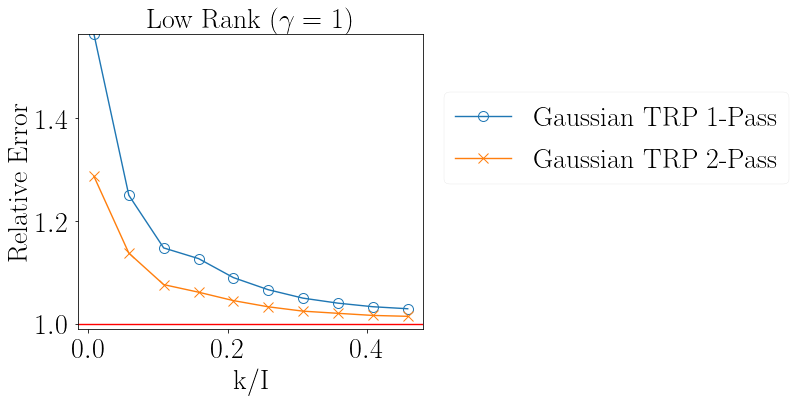

0.9999403586986221


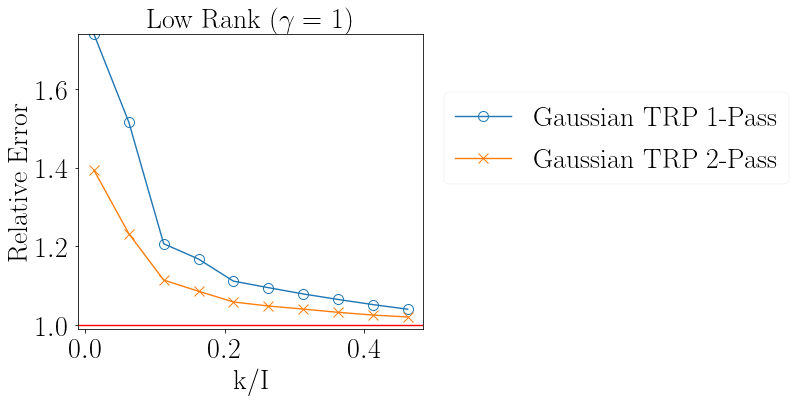

0.9995257431766934


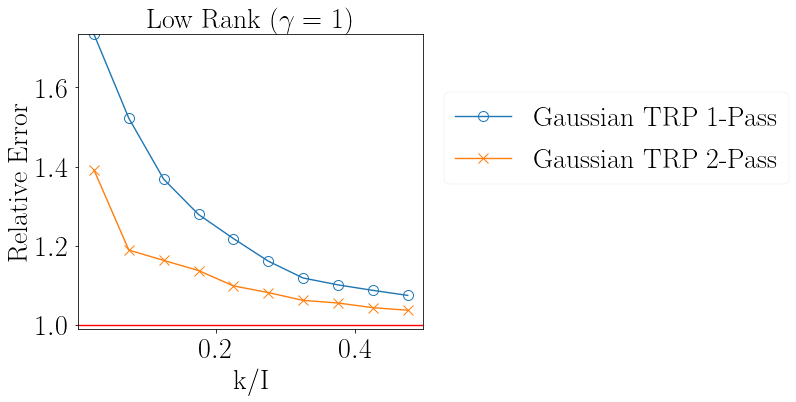

0.09999494076927937


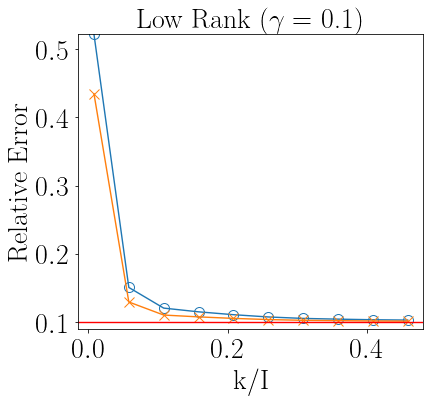

0.099994033655215


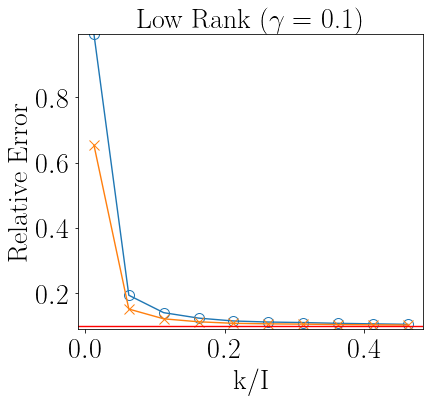

0.09995258297650764


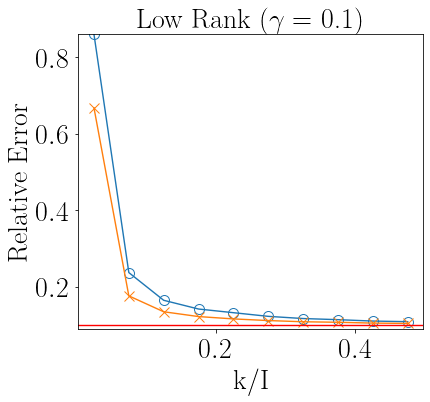

0.009999494076880899


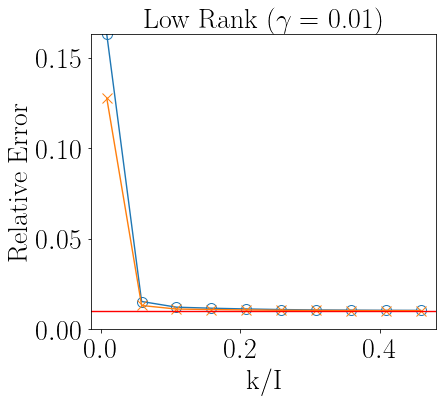

0.009999403340135455


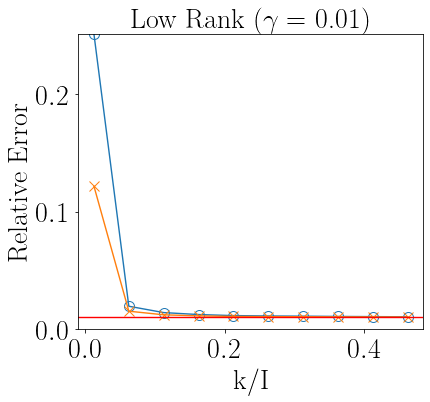

0.009995258326516382


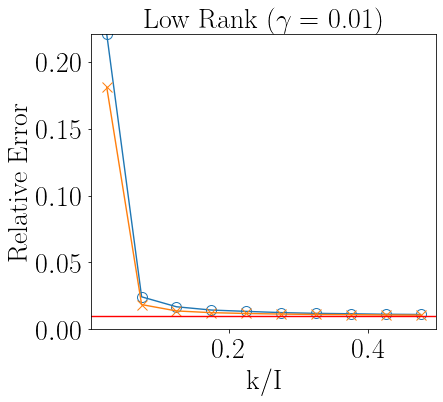

0.3376195073544071


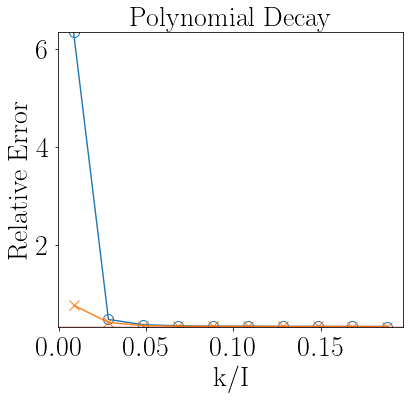

0.3374228001747853


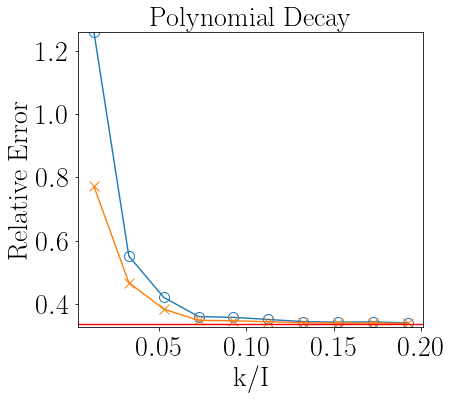

0.3368246071121475


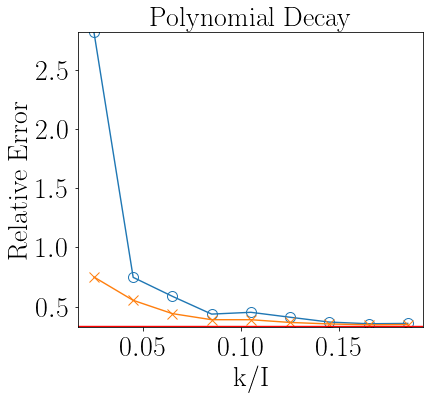

In [8]:
journal_nssim2(['gprod'], 'lk',5,1,"fig3_lk_hnoise_600.pdf",600, outside = True)
journal_nssim2(['gprod'], 'lk',5,1,"fig3_lk_hnoise_400.pdf",400, outside = True)
journal_nssim2(['gprod'], 'lk',5,1,"fig3_lk_hnoise_200.pdf",200, outside = True)
journal_nssim2(['gprod'], 'lk',5,0.1,"fig3_lk_mnoise_600.pdf",600)
journal_nssim2(['gprod'], 'lk',5,0.1,"fig3_lk_mnoise_400.pdf",400)
journal_nssim2(['gprod'], 'lk',5,0.1,"fig3_lk_mnoise_200.pdf",200)
journal_nssim2(['gprod'], 'lk',5,0.01,"fig3_lk_lnoise_600.pdf",600)
journal_nssim2(['gprod'], 'lk',5,0.01,"fig3_lk_lnoise_400.pdf",400)
journal_nssim2(['gprod'], 'lk',5,0.01,"fig3_lk_lnoise_200.pdf",200)
# journal_nssim2(['gprod'], 'slk',5,0.01,"fig3_slk_lnoise_600.pdf",600)
# journal_nssim2(['gprod'], 'slk',5,0.01,"fig3_slk_lnoise_400.pdf",400)
# journal_nssim2(['gprod'], 'slk',5,0.01,"fig3_slk_lnoise_200.pdf",200)
journal_nssim2(['gprod'], 'spd',5,0.01,"fig3_spd_600.pdf",600)
journal_nssim2(['gprod'], 'spd',5,0.01,"fig3_spd_400.pdf",400)
journal_nssim2(['gprod'], 'spd',5,0.01,"fig3_spd_200.pdf",200)

# Implementation actually problematic: the code needs to aggregate multiple runs

# Speed comparison

In [ ]:
def journal_nssim_time(rm_typs,gen_type,r,noise_level,name,n, ns = [200,400,600], dim = 3, sim_runs = 1,random_seed = 1,fontsize = 28, outside = False, ONE_PASS = True, TWO_PASS = True): 
    '''
    Plot the simulation results from l in the log scale. The plotted error is log(err(one or two pass)) - log(err(hooi)) 
    '''
    plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    plt.rc('text', usetex=True)
    if outside: 
        plt.figure(figsize = (7,5))
    else: 
        plt.figure(figsize=(6,5))
    ymaxs = []
    ymins = []
    alldata = []
    for i,rm_typ in enumerate(rm_typs): 
        sim_time = pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+"_time.pickle", "rb" ) )
        sim_acc = pickle.load( open(sim_name(gen_type,r,noise_level,dim,rm_typ)+".pickle", "rb" ) )
        plot_id = ns.index(n)
        
        if rm_typ == 'gprod':
            hosvd_acc = np.mean(sim_acc[plot_id][2],0)[0]
            hosvd_time = np.mean(sim_time[1][plot_id][2],0)[0]
            plt.plot(hosvd_time, hosvd_acc, label = "HOOI", markersize = 10, marker = marker('hooi', rm_typ), markeredgewidth=1, markerfacecolor='None') 

        two_pass_acc = [np.mean(sim_acc[plot_id][1],0)[i]  for i in [1,3,7]]
        two_pass_time = [(np.mean(sim_time[0][plot_id][0],0)+np.mean(sim_time[1][plot_id][0],0))[i] for i in [1,3,7]]
        
        one_pass_acc = [np.mean(sim_acc[plot_id][0],0)[i] for i in [1,3,7]]
        one_pass_time = [(np.mean(sim_time[0][plot_id][1],0)+np.mean(sim_time[1][plot_id][1],0))[i] for i in [1,3,7]]
        if ONE_PASS: 
            # Sort the output: 
            list1, list2 = zip(*sorted(zip(one_pass_time,one_pass_acc)))
            plt.plot(list1, list2, label = find_rm_label(rm_typ)+" 1-Pass", markersize = 10, marker = marker('1pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
            alldata.append(list2)
        if TWO_PASS:
            list1, list2 = zip(*sorted(zip(two_pass_time,two_pass_acc)))
            plt.plot(list1, list2, label = find_rm_label(rm_typ)+" 2-Pass", markersize = 10, marker = marker('2pass', rm_typ), markeredgewidth=1, markerfacecolor='None') 
            alldata.append(list2)
    
    alldata = np.concatenate(alldata)
    #plt.ylim(0.05, 0.35)
    if outside: 
        plt.legend(fontsize = fontsize, bbox_to_anchor=(1.25, 1))
    if gen_type in ['lk','slk']:
        plt.title(find_gen_label(gen_type)+" ($\gamma=$ "+str(noise_level)+")")
    else: 
        plt.title(find_gen_label(gen_type))   
    plt.xlabel('Time (s)')
    plt.ylabel('Normalized Error')
    #plt.yscale('log')
    plt.axes().title.set_fontsize(fontsize)
    plt.axes().xaxis.label.set_fontsize(fontsize)
    plt.axes().yaxis.label.set_fontsize(fontsize)

    plt.rc('legend',fontsize = fontsize)
    plt.rc('xtick', labelsize = fontsize) 
    plt.rc('ytick', labelsize = fontsize) 
    plt.tight_layout()
    plt.savefig('plots/journal/'+name,bbox_inches = "tight",pad_inches=0)
    plt.show()

In [ ]:
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'lk',5,0.01,"lk_1pass_time.pdf",600, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'slk',5,0.01,"slk_1pass_time.pdf",600, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'lk',5,0.01,"lk_2pass_time.pdf",600, ONE_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'slk',5,0.01,"slk_2pass_time.pdf",600, ONE_PASS=False)

In [ ]:
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'spd',5,0.01,"spd_1pass_time.pdf",600, outside = True, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'fpd',5,0.01,"fpd_1pass_time.pdf",600, outside = True, TWO_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'spd',5,0.01,"spd_2pass_time.pdf",600, outside = True, ONE_PASS=False)
journal_nssim_time(['gprod','sp0prod','g','sp0'], 'fpd',5,0.01,"fpd_2pass_time.pdf",600, outside = True, ONE_PASS=False)